# Transfer Learning on CIFAR-10 with ResNet50 and EfficientNetB0

In this notebook, we use **pretrained models** like **ResNet50** and **EfficientNetB0** from Keras Applications to classify images from the **CIFAR-10** dataset using Transfer Learning.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

In [1]:
rm -rf ~/.keras/models/

## Step 1: Load and Preprocess CIFAR-10

- Normalize the images
- Resize them to 224x224 (required for pretrained models)

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize to [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

# Resize to 224x224 for pretrained model compatibility
X_train_resized = tf.image.resize(X_train, (224, 224))
X_test_resized = tf.image.resize(X_test, (224, 224))

# If grayscale accidentally appears, convert to RGB
if X_train_resized.shape[-1] == 1:
    X_train_resized = tf.image.grayscale_to_rgb(X_train_resized)
    X_test_resized = tf.image.grayscale_to_rgb(X_test_resized)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
print(X_train.shape, X_train_resized.shape)
print("Channels in resized image:", X_train_resized.shape[-1])

(50000, 32, 32, 3) (50000, 224, 224, 3)
Channels in resized image: 3


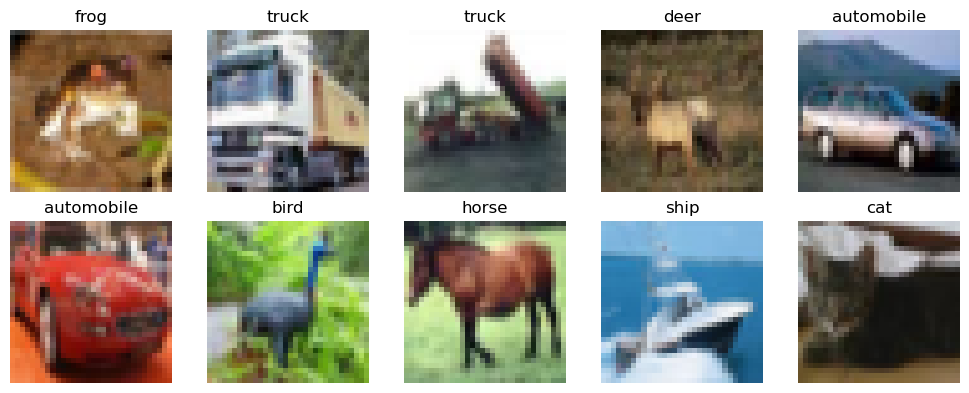

In [4]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis("off")
plt.tight_layout()
plt.show()

## Step 2: ResNet50 Model

We load ResNet50 pretrained on ImageNet, freeze its layers, and add custom Dense layers.

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

resnet_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
resnet_model.summary()

In [ ]:
resnet_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

history_resnet = resnet_model.fit(X_train_resized, y_train, epochs=5, batch_size=64, validation_split=0.1)

## Step 3: EfficientNetB0 Model

EfficientNet is a family of models that balance accuracy and speed. We'll use the smallest variant.

In [5]:
import shutil, os
shutil.rmtree(os.path.expanduser("~/.keras/models"), ignore_errors=True)

In [6]:
efficient_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficient_base.trainable = False

efficient_model = Sequential([
    efficient_base,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
efficient_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [ ]:
resnet_loss, resnet_acc = resnet_model.evaluate(X_test_resized, y_test)
# eff_loss, eff_acc = efficient_model.evaluate(X_test_resized, y_test)

print(f"✅ ResNet50 Test Accuracy: {resnet_acc:.2f}")
# print(f"✅ EfficientNetB0 Test Accuracy: {eff_acc:.2f}")

In [ ]:
preds = efficient_model.predict(X_test_resized[:5])
predicted = np.argmax(preds, axis=1)

for i in range(5):
    plt.imshow(X_test[i])
    plt.title(f"Predicted: {class_names[predicted[i]]} | Actual: {class_names[y_test[i][0]]}")
    plt.axis("off")
    plt.show()